# Etapa 2: Preparação e Tratamento dos Dados (20%)

## Objetivo
Realizar limpeza, transformação e engenharia de features nos dados de séries temporais, preparando-os adequadamente para modelagem preditiva.

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


In [2]:
# Carregar dados da etapa anterior
df = pd.read_csv('dados_explorados.csv', parse_dates=['Date'])

print(f"Dataset carregado: {df.shape}")
print(f"Período: {df['Date'].min()} até {df['Date'].max()}")
df.head()

Dataset carregado: (4950, 13)
Período: 2015-07-01 00:00:00 até 2016-12-31 00:00:00


,Page,Date,Views,Page_Name,Project,Access,Agent,Year,Month,DayOfWeek,DayOfWeekName,Quarter,WeekOfYear
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,2NE1,zh.wikipedia.org,all-access,spider,2015,7,2,Wednesday,3,27
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,2PM,zh.wikipedia.org,all-access,spider,2015,7,2,Wednesday,3,27
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,3C,zh.wikipedia.org,all-access,spider,2015,7,2,Wednesday,3,27
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,4minute,zh.wikipedia.org,all-access,spider,2015,7,2,Wednesday,3,27
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider,2015,7,2,Wednesday,3,27


## 1. Tratamento de Valores Ausentes

In [3]:
# Análise de valores ausentes
print("=" * 60)
print("ANÁLISE DE VALORES AUSENTES")
print("=" * 60)

missing_summary = pd.DataFrame({
    'Total': df.isnull().sum(),
    'Percentual': (df.isnull().sum() / len(df)) * 100
})
print(missing_summary[missing_summary['Total'] > 0])

# Análise por página
print("\nValores ausentes por página:")
missing_by_page = df.groupby('Page')['Views'].apply(lambda x: x.isnull().sum())
print(missing_by_page[missing_by_page > 0])

ANÁLISE DE VALORES AUSENTES
       Total  Percentual
Views    656   13.252525

Valores ausentes por página:
Page
52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider    291
91Days_zh.wikipedia.org_all-access_spider              365
Name: Views, dtype: int64


In [4]:
# Estratégias de imputação
df_cleaned = df.copy()

print("Aplicando estratégias de imputação...\n")

for page in df_cleaned['Page'].unique():
    page_mask = df_cleaned['Page'] == page
    page_data = df_cleaned[page_mask].sort_values('Date').copy()
    
    # Verificar se há valores ausentes
    if page_data['Views'].isnull().any():
        print(f"Tratando página: {page[:40]}...")
        
        # Estratégia 1: Interpolação linear para gaps pequenos (< 7 dias)
        page_data['Views'] = page_data['Views'].interpolate(method='linear', limit=7)
        
        # Estratégia 2: Forward fill para gaps no início
        page_data['Views'] = page_data['Views'].fillna(method='bfill', limit=3)
        
        # Estratégia 3: Preencher valores restantes com mediana da série
        median_value = page_data['Views'].median()
        page_data['Views'] = page_data['Views'].fillna(median_value)
        
        # Atualizar no dataframe principal
        df_cleaned.loc[page_mask, 'Views'] = page_data['Views'].values
        
        print(f"  ✓ Valores imputados: {page_data['Views'].isnull().sum() == 0}")

print("\n" + "=" * 60)
print("Verificação pós-imputação:")
print(f"Valores ausentes restantes: {df_cleaned['Views'].isnull().sum()}")
print("=" * 60)

Aplicando estratégias de imputação...

Tratando página: 52_Hz_I_Love_You_zh.wikipedia.org_all-ac...
  ✓ Valores imputados: True
Tratando página: 91Days_zh.wikipedia.org_all-access_spide...
  ✓ Valores imputados: True

Verificação pós-imputação:
Valores ausentes restantes: 0


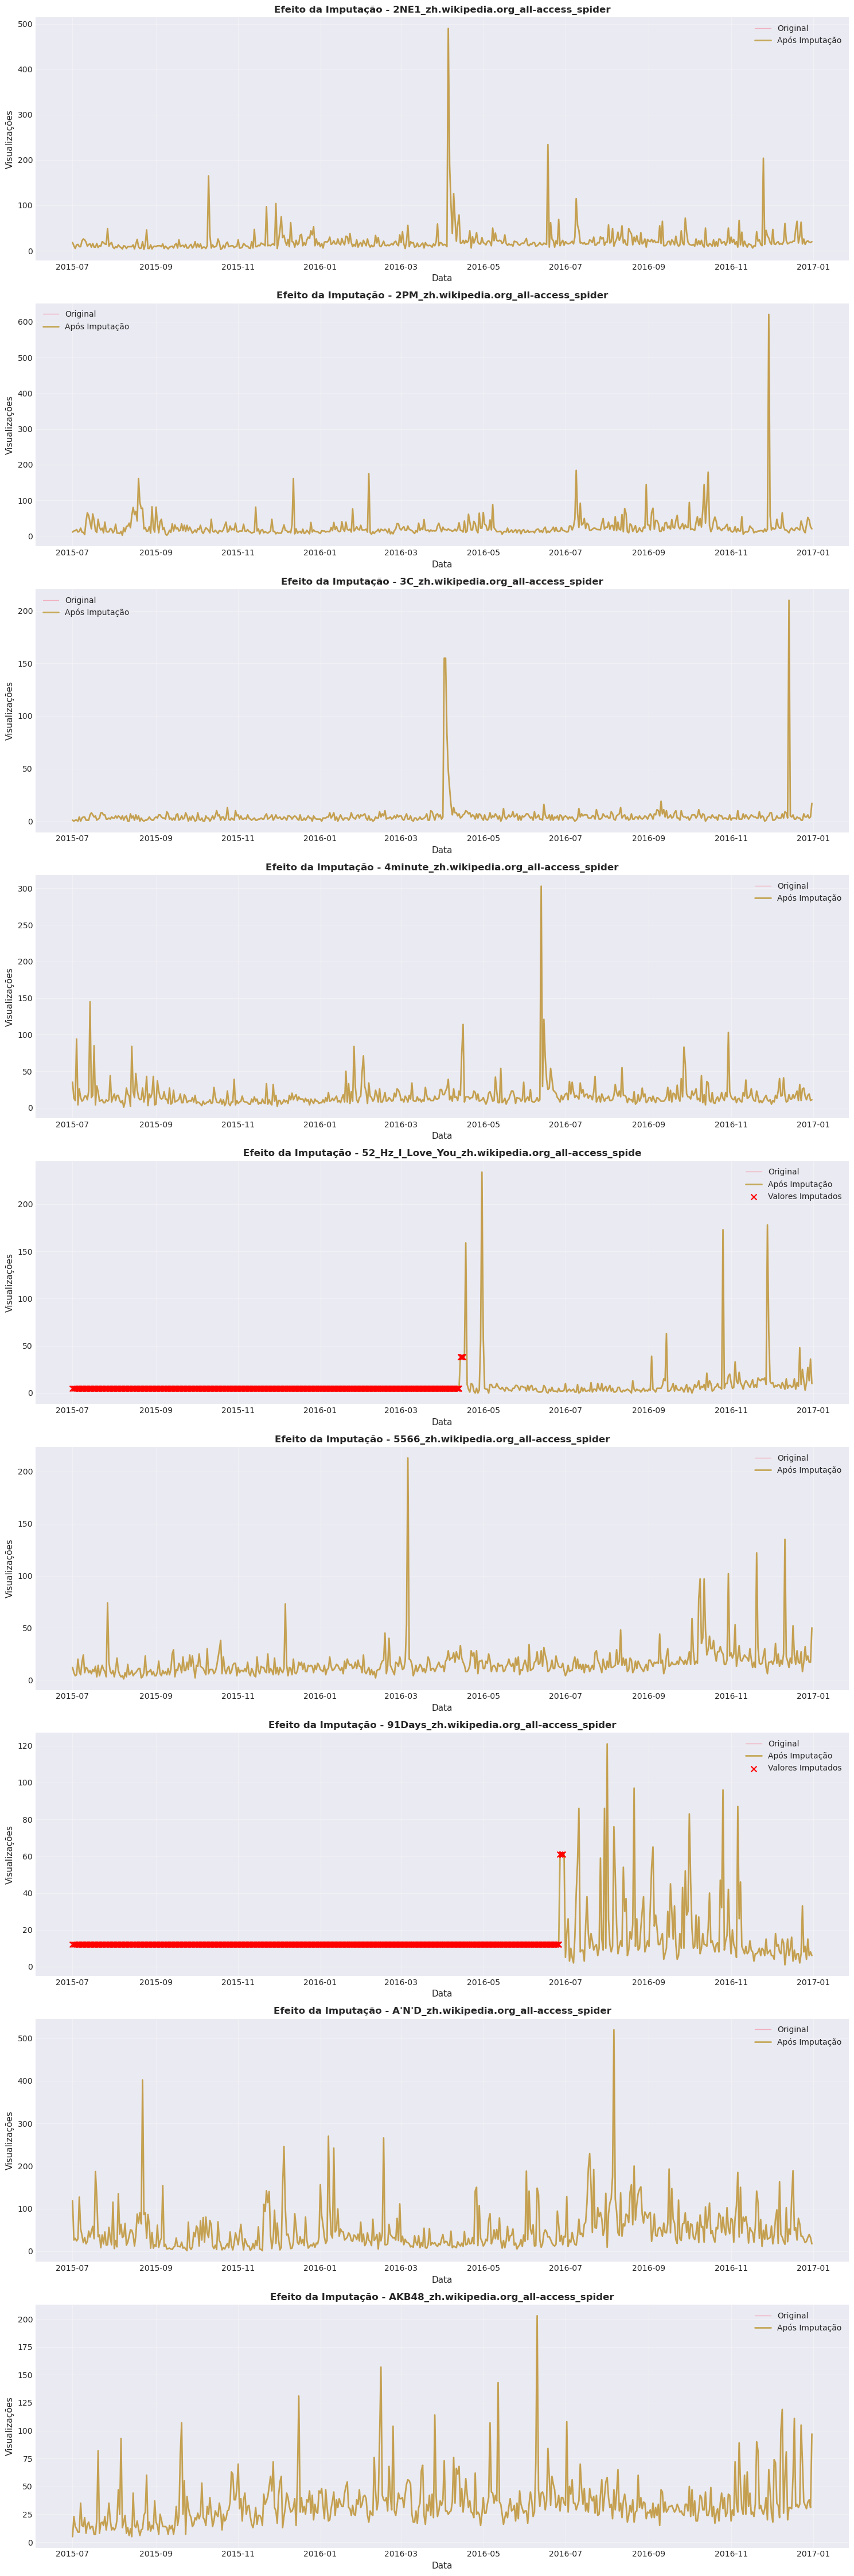

In [5]:
# Visualização do efeito da imputação
fig, axes = plt.subplots(len(df['Page'].unique()), 1, 
                        figsize=(15, 5*len(df['Page'].unique())))

if len(df['Page'].unique()) == 1:
    axes = [axes]

for idx, page in enumerate(df['Page'].unique()):
    original = df[df['Page'] == page].sort_values('Date')
    cleaned = df_cleaned[df_cleaned['Page'] == page].sort_values('Date')
    
    axes[idx].plot(original['Date'], original['Views'], 
                   alpha=0.5, label='Original', linewidth=1)
    axes[idx].plot(cleaned['Date'], cleaned['Views'], 
                   alpha=0.8, label='Após Imputação', linewidth=2)
    
    # Marcar pontos imputados
    missing_mask = original['Views'].isnull()
    if missing_mask.any():
        imputed_dates = original[missing_mask]['Date']
        imputed_values = cleaned[cleaned['Date'].isin(imputed_dates)]['Views']
        axes[idx].scatter(imputed_dates, imputed_values, 
                         color='red', s=50, marker='x', 
                         label='Valores Imputados', zorder=5)
    
    axes[idx].set_title(f'Efeito da Imputação - {page[:50]}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Data', fontsize=11)
    axes[idx].set_ylabel('Visualizações', fontsize=11)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Tratamento de Outliers

In [6]:
# Função para detectar outliers usando IQR
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

# Função para detectar outliers usando Z-score
def detect_outliers_zscore(series, threshold=3):
    z_scores = np.abs((series - series.mean()) / series.std())
    return z_scores > threshold

# Criar dataframe para armazenar outliers antes do tratamento
df_outliers_original = df_cleaned.copy()

print("=" * 60)
print("TRATAMENTO DE OUTLIERS")
print("=" * 60)

for page in df_cleaned['Page'].unique():
    page_mask = df_cleaned['Page'] == page
    page_data = df_cleaned[page_mask].sort_values('Date').copy()
    
    # Detectar outliers usando IQR
    outliers_iqr = detect_outliers_iqr(page_data['Views'])
    outliers_zscore = detect_outliers_zscore(page_data['Views'])
    
    # Combinar ambos os métodos (considerar outlier se detectado por ambos)
    outliers = outliers_iqr & outliers_zscore
    
    if outliers.sum() > 0:
        print(f"\nPágina: {page[:40]}")
        print(f"  Outliers detectados: {outliers.sum()}")
        
        # Estratégia: Winsorização (cap nos percentis 5 e 95)
        lower_cap = page_data['Views'].quantile(0.05)
        upper_cap = page_data['Views'].quantile(0.95)
        
        page_data.loc[outliers, 'Views'] = page_data.loc[outliers, 'Views'].clip(
            lower=lower_cap, upper=upper_cap
        )
        
        # Atualizar no dataframe principal
        df_cleaned.loc[page_mask, 'Views'] = page_data['Views'].values
        
        print(f"  ✓ Outliers tratados com Winsorização (caps: {lower_cap:.2f}, {upper_cap:.2f})")

print("\n" + "=" * 60)

TRATAMENTO DE OUTLIERS

Página: 2NE1_zh.wikipedia.org_all-access_spider
  Outliers detectados: 7
  ✓ Outliers tratados com Winsorização (caps: 6.00, 55.00)

Página: 2PM_zh.wikipedia.org_all-access_spider
  Outliers detectados: 8
  ✓ Outliers tratados com Winsorização (caps: 8.00, 64.55)

Página: 3C_zh.wikipedia.org_all-access_spider
  Outliers detectados: 5
  ✓ Outliers tratados com Winsorização (caps: 1.00, 10.00)

Página: 4minute_zh.wikipedia.org_all-access_spid
  Outliers detectados: 10
  ✓ Outliers tratados com Winsorização (caps: 5.45, 40.00)

Página: 52_Hz_I_Love_You_zh.wikipedia.org_all-ac
  Outliers detectados: 6
  ✓ Outliers tratados com Winsorização (caps: 2.00, 14.55)

Página: 5566_zh.wikipedia.org_all-access_spider
  Outliers detectados: 9
  ✓ Outliers tratados com Winsorização (caps: 5.00, 32.55)

Página: 91Days_zh.wikipedia.org_all-access_spide
  Outliers detectados: 17
  ✓ Outliers tratados com Winsorização (caps: 7.00, 38.00)

Página: A'N'D_zh.wikipedia.org_all-access_s

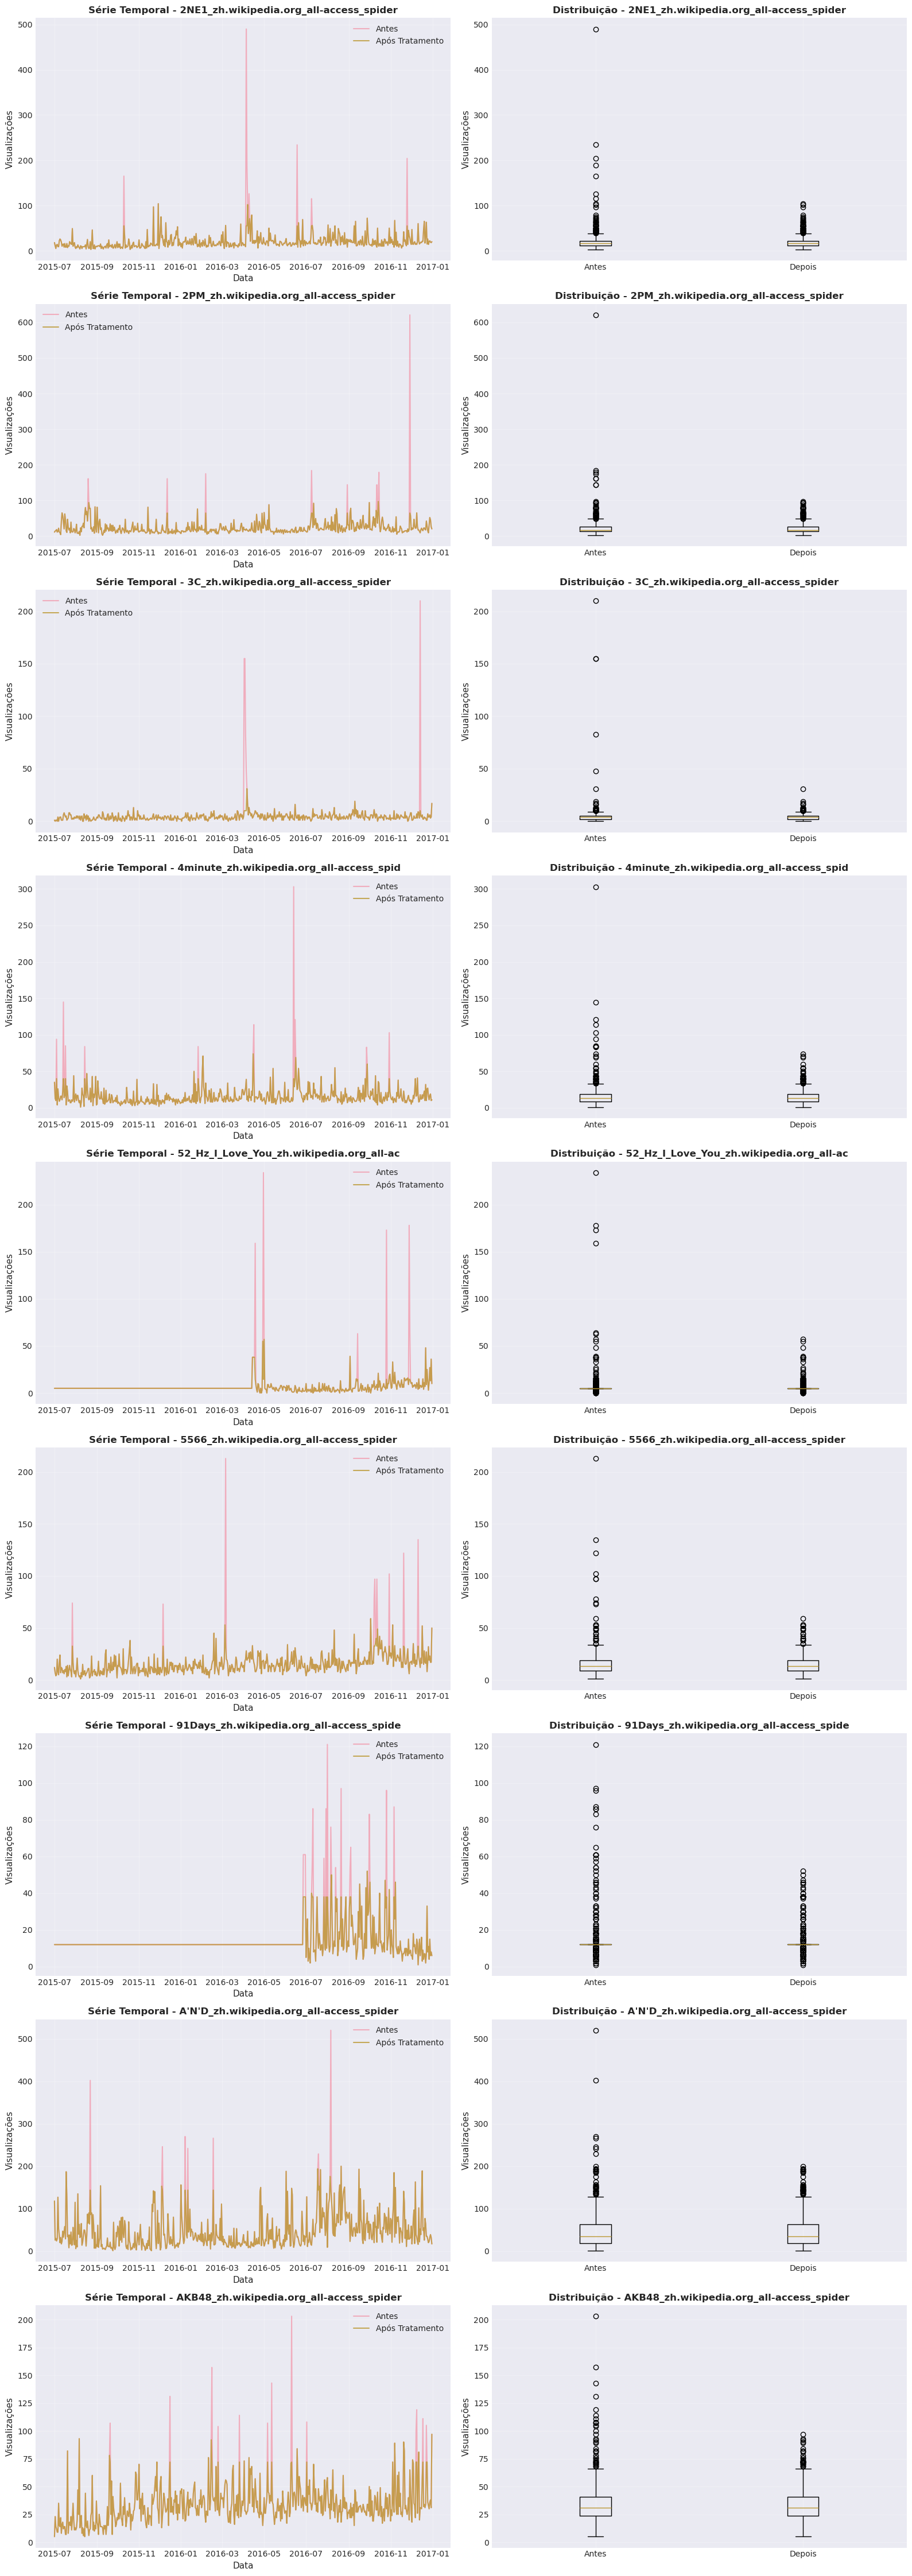


Estatísticas antes e depois do tratamento de outliers:

2NE1_zh.wikipedia.org_all-access_spider:
  Antes:
    Média: 21.76
    Std: 29.39
  Depois:
    Média: 19.69
    Std: 14.41

2PM_zh.wikipedia.org_all-access_spider:
  Antes:
    Média: 25.39
    Std: 33.98
  Depois:
    Média: 23.12
    Std: 16.68

3C_zh.wikipedia.org_all-access_spider:
  Antes:
    Média: 5.20
    Std: 13.51
  Depois:
    Média: 4.11
    Std: 2.99

4minute_zh.wikipedia.org_all-access_spid:
  Antes:
    Média: 17.13
    Std: 19.34
  Depois:
    Média: 15.64
    Std: 10.44

52_Hz_I_Love_You_zh.wikipedia.org_all-ac:
  Antes:
    Média: 7.67
    Std: 16.90
  Depois:
    Média: 6.24
    Std: 5.93

5566_zh.wikipedia.org_all-access_spider:
  Antes:
    Média: 16.41
    Std: 15.67
  Depois:
    Média: 15.14
    Std: 8.73

91Days_zh.wikipedia.org_all-access_spide:
  Antes:
    Média: 14.85
    Std: 12.75
  Depois:
    Média: 13.73
    Std: 7.57

A'N'D_zh.wikipedia.org_all-access_spider:
  Antes:
    Média: 49.65
    Std:

In [7]:
# Visualização do efeito do tratamento de outliers
fig, axes = plt.subplots(len(df['Page'].unique()), 2, 
                        figsize=(16, 5*len(df['Page'].unique())))

if len(df['Page'].unique()) == 1:
    axes = axes.reshape(1, -1)

for idx, page in enumerate(df['Page'].unique()):
    original = df_outliers_original[df_outliers_original['Page'] == page].sort_values('Date')
    treated = df_cleaned[df_cleaned['Page'] == page].sort_values('Date')
    
    # Série temporal
    axes[idx, 0].plot(original['Date'], original['Views'], 
                      alpha=0.5, label='Antes', linewidth=1.5)
    axes[idx, 0].plot(treated['Date'], treated['Views'], 
                      alpha=0.8, label='Após Tratamento', linewidth=1.5)
    axes[idx, 0].set_title(f'Série Temporal - {page[:40]}', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Data', fontsize=11)
    axes[idx, 0].set_ylabel('Visualizações', fontsize=11)
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Boxplot comparativo
    data_to_plot = [original['Views'].dropna(), treated['Views'].dropna()]
    axes[idx, 1].boxplot(data_to_plot, labels=['Antes', 'Depois'])
    axes[idx, 1].set_title(f'Distribuição - {page[:40]}', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Visualizações', fontsize=11)
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas comparativas
print("\nEstatísticas antes e depois do tratamento de outliers:")
for page in df['Page'].unique():
    print(f"\n{page[:40]}:")
    print("  Antes:")
    print(f"    Média: {df_outliers_original[df_outliers_original['Page'] == page]['Views'].mean():.2f}")
    print(f"    Std: {df_outliers_original[df_outliers_original['Page'] == page]['Views'].std():.2f}")
    print("  Depois:")
    print(f"    Média: {df_cleaned[df_cleaned['Page'] == page]['Views'].mean():.2f}")
    print(f"    Std: {df_cleaned[df_cleaned['Page'] == page]['Views'].std():.2f}")

## 3. Engenharia de Features Temporais

In [8]:
print("=" * 60)
print("ENGENHARIA DE FEATURES TEMPORAIS")
print("=" * 60)

# Features de data
df_cleaned['Year'] = df_cleaned['Date'].dt.year
df_cleaned['Month'] = df_cleaned['Date'].dt.month
df_cleaned['Day'] = df_cleaned['Date'].dt.day
df_cleaned['DayOfWeek'] = df_cleaned['Date'].dt.dayofweek
df_cleaned['DayOfYear'] = df_cleaned['Date'].dt.dayofyear
df_cleaned['WeekOfYear'] = df_cleaned['Date'].dt.isocalendar().week
df_cleaned['Quarter'] = df_cleaned['Date'].dt.quarter
df_cleaned['IsWeekend'] = (df_cleaned['DayOfWeek'] >= 5).astype(int)

# Features cíclicas (sen/cos para capturar natureza cíclica)
df_cleaned['DayOfWeek_sin'] = np.sin(2 * np.pi * df_cleaned['DayOfWeek'] / 7)
df_cleaned['DayOfWeek_cos'] = np.cos(2 * np.pi * df_cleaned['DayOfWeek'] / 7)
df_cleaned['Month_sin'] = np.sin(2 * np.pi * df_cleaned['Month'] / 12)
df_cleaned['Month_cos'] = np.cos(2 * np.pi * df_cleaned['Month'] / 12)
df_cleaned['DayOfYear_sin'] = np.sin(2 * np.pi * df_cleaned['DayOfYear'] / 365)
df_cleaned['DayOfYear_cos'] = np.cos(2 * np.pi * df_cleaned['DayOfYear'] / 365)

print("✓ Features temporais básicas criadas")

# Features de lag (valores passados)
print("\nCriando features de lag...")
lag_periods = [1, 7, 14, 30]  # 1 dia, 1 semana, 2 semanas, 1 mês

for page in df_cleaned['Page'].unique():
    page_mask = df_cleaned['Page'] == page
    page_data = df_cleaned[page_mask].sort_values('Date').copy()
    
    for lag in lag_periods:
        page_data[f'Views_lag_{lag}'] = page_data['Views'].shift(lag)
    
    # Atualizar no dataframe principal
    for lag in lag_periods:
        df_cleaned.loc[page_mask, f'Views_lag_{lag}'] = page_data[f'Views_lag_{lag}'].values

print(f"✓ Features de lag criadas: {lag_periods}")

# Features de rolling window (estatísticas móveis)
print("\nCriando features de rolling window...")
window_sizes = [7, 14, 30]  # janelas de 7, 14 e 30 dias

for page in df_cleaned['Page'].unique():
    page_mask = df_cleaned['Page'] == page
    page_data = df_cleaned[page_mask].sort_values('Date').copy()
    
    for window in window_sizes:
        page_data[f'Views_rolling_mean_{window}'] = page_data['Views'].rolling(window=window).mean()
        page_data[f'Views_rolling_std_{window}'] = page_data['Views'].rolling(window=window).std()
        page_data[f'Views_rolling_min_{window}'] = page_data['Views'].rolling(window=window).min()
        page_data[f'Views_rolling_max_{window}'] = page_data['Views'].rolling(window=window).max()
    
    # Atualizar no dataframe principal
    for window in window_sizes:
        df_cleaned.loc[page_mask, f'Views_rolling_mean_{window}'] = page_data[f'Views_rolling_mean_{window}'].values
        df_cleaned.loc[page_mask, f'Views_rolling_std_{window}'] = page_data[f'Views_rolling_std_{window}'].values
        df_cleaned.loc[page_mask, f'Views_rolling_min_{window}'] = page_data[f'Views_rolling_min_{window}'].values
        df_cleaned.loc[page_mask, f'Views_rolling_max_{window}'] = page_data[f'Views_rolling_max_{window}'].values

print(f"✓ Features de rolling window criadas: {window_sizes}")

# Features de diferenciação
print("\nCriando features de diferenciação...")
for page in df_cleaned['Page'].unique():
    page_mask = df_cleaned['Page'] == page
    page_data = df_cleaned[page_mask].sort_values('Date').copy()
    
    page_data['Views_diff_1'] = page_data['Views'].diff(1)  # Primeira diferença
    page_data['Views_diff_7'] = page_data['Views'].diff(7)  # Diferença semanal
    page_data['Views_pct_change_1'] = page_data['Views'].pct_change(1)  # Mudança percentual diária
    page_data['Views_pct_change_7'] = page_data['Views'].pct_change(7)  # Mudança percentual semanal
    
    # Atualizar no dataframe principal
    df_cleaned.loc[page_mask, 'Views_diff_1'] = page_data['Views_diff_1'].values
    df_cleaned.loc[page_mask, 'Views_diff_7'] = page_data['Views_diff_7'].values
    df_cleaned.loc[page_mask, 'Views_pct_change_1'] = page_data['Views_pct_change_1'].values
    df_cleaned.loc[page_mask, 'Views_pct_change_7'] = page_data['Views_pct_change_7'].values

print("✓ Features de diferenciação criadas")

print("\n" + "=" * 60)
print(f"Total de features criadas: {len(df_cleaned.columns) - len(df.columns)}")
print("=" * 60)

ENGENHARIA DE FEATURES TEMPORAIS
✓ Features temporais básicas criadas

Criando features de lag...
✓ Features de lag criadas: [1, 7, 14, 30]

Criando features de rolling window...
✓ Features de rolling window criadas: [7, 14, 30]

Criando features de diferenciação...
✓ Features de diferenciação criadas

Total de features criadas: 29


In [9]:
# Visualizar features criadas
print("\nExemplo de features criadas:")
feature_columns = [col for col in df_cleaned.columns if col not in df.columns]
print(df_cleaned[['Date', 'Page', 'Views'] + feature_columns[:10]].head(15))


Exemplo de features criadas:
         Date                                               Page  Views  Day  \
0  2015-07-01            2NE1_zh.wikipedia.org_all-access_spider   18.0    1   
1  2015-07-01             2PM_zh.wikipedia.org_all-access_spider   11.0    1   
2  2015-07-01              3C_zh.wikipedia.org_all-access_spider    1.0    1   
3  2015-07-01         4minute_zh.wikipedia.org_all-access_spider   35.0    1   
4  2015-07-01  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...    5.0    1   
5  2015-07-01            5566_zh.wikipedia.org_all-access_spider   12.0    1   
6  2015-07-01          91Days_zh.wikipedia.org_all-access_spider   12.0    1   
7  2015-07-01           A'N'D_zh.wikipedia.org_all-access_spider  118.0    1   
8  2015-07-01           AKB48_zh.wikipedia.org_all-access_spider    5.0    1   
9  2015-07-02            2NE1_zh.wikipedia.org_all-access_spider   11.0    2   
10 2015-07-02             2PM_zh.wikipedia.org_all-access_spider   14.0    2   
11 2015-07

## 4. Normalização e Padronização

In [10]:
print("=" * 60)
print("NORMALIZAÇÃO E PADRONIZAÇÃO")
print("=" * 60)

# ============================================================================
# PASSO 1: Tratar valores infinitos e extremos
# ============================================================================
print("\n1. Tratando valores infinitos e extremos...")

# Criar cópias para diferentes estratégias
df_standardized = df_cleaned.copy()
df_normalized = df_cleaned.copy()

# Colunas numéricas para escalonar (excluir datas e categóricas)
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 
                'Quarter', 'IsWeekend']
cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

print(f"   Colunas a serem escalonadas: {len(cols_to_scale)}")

# Substituir infinitos por NaN
for df in [df_cleaned, df_standardized, df_normalized]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("   ✓ Valores infinitos convertidos para NaN")

# Verificar e clipar valores extremos
n_extreme_total = 0
for col in cols_to_scale:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        # Contar valores extremos
        n_extreme = ((df_cleaned[col].abs() > 1e10) & (df_cleaned[col].notna())).sum()
        n_extreme_total += n_extreme
        
        if n_extreme > 0:
            # Clipar ao percentil 99.9/0.1
            upper = df_cleaned[col].quantile(0.999)
            lower = df_cleaned[col].quantile(0.001)
            
            for df in [df_cleaned, df_standardized, df_normalized]:
                df.loc[:, col] = df[col].clip(lower=lower, upper=upper)

if n_extreme_total > 0:
    print(f"   ✓ {n_extreme_total} valores extremos tratados")
else:
    print("   ✓ Nenhum valor extremo detectado")

# ============================================================================
# PASSO 2: Padronização (StandardScaler)
# ============================================================================
print("\n2. Aplicando StandardScaler por página...")
scaler_standard = StandardScaler()

for page in df_standardized['Page'].unique():
    page_mask = df_standardized['Page'] == page
    page_data = df_standardized[page_mask][cols_to_scale].copy()
    
    # Preencher NaN com mediana
    for col in cols_to_scale:
        if page_data[col].isnull().any():
            median_val = page_data[col].median()
            if pd.isna(median_val):  # Se mediana também é NaN, usar 0
                median_val = 0
            page_data[col] = page_data[col].fillna(median_val)
    
    # Verificar se ainda há problemas
    if page_data.isnull().any().any():
        print(f"   Aviso: Ainda há NaN em {page[:30]}... preenchendo com 0")
        page_data = page_data.fillna(0)
    
    # Aplicar StandardScaler
    try:
        scaled_data = scaler_standard.fit_transform(page_data)
        df_standardized.loc[page_mask, cols_to_scale] = scaled_data
    except Exception as e:
        print(f"   Erro em {page[:30]}: {e}")
        # Em caso de erro, manter valores originais
        continue

print("✓ Padronização (Z-score) aplicada")

# ============================================================================
# PASSO 3: Normalização (MinMaxScaler)
# ============================================================================
print("\n3. Aplicando MinMaxScaler por página...")
scaler_minmax = MinMaxScaler()

for page in df_normalized['Page'].unique():
    page_mask = df_normalized['Page'] == page
    page_data = df_normalized[page_mask][cols_to_scale].copy()
    
    # Preencher NaN com mediana
    for col in cols_to_scale:
        if page_data[col].isnull().any():
            median_val = page_data[col].median()
            if pd.isna(median_val):  # Se mediana também é NaN, usar 0
                median_val = 0
            page_data[col] = page_data[col].fillna(median_val)
    
    # Verificar se ainda há problemas
    if page_data.isnull().any().any():
        print(f"   Aviso: Ainda há NaN em {page[:30]}... preenchendo com 0")
        page_data = page_data.fillna(0)
    
    # Aplicar MinMaxScaler
    try:
        scaled_data = scaler_minmax.fit_transform(page_data)
        df_normalized.loc[page_mask, cols_to_scale] = scaled_data
    except Exception as e:
        print(f"   Erro em {page[:30]}: {e}")
        # Em caso de erro, manter valores originais
        continue

print("✓ Normalização (Min-Max) aplicada")

print("\n" + "=" * 60)

# Verificação final
print("\nVerificação final:")
print(f"  NaN em df_standardized: {df_standardized[cols_to_scale].isnull().sum().sum()}")
print(f"  NaN em df_normalized: {df_normalized[cols_to_scale].isnull().sum().sum()}")
print(f"  Inf em df_standardized: {np.isinf(df_standardized[cols_to_scale]).sum().sum()}")
print(f"  Inf em df_normalized: {np.isinf(df_normalized[cols_to_scale]).sum().sum()}")

NORMALIZAÇÃO E PADRONIZAÇÃO

1. Tratando valores infinitos e extremos...
   Colunas a serem escalonadas: 27
   ✓ Valores infinitos convertidos para NaN
   ✓ Nenhum valor extremo detectado

2. Aplicando StandardScaler por página...
✓ Padronização (Z-score) aplicada

3. Aplicando MinMaxScaler por página...
✓ Normalização (Min-Max) aplicada


Verificação final:
  NaN em df_standardized: 0
  NaN em df_normalized: 0
  Inf em df_standardized: 0
  Inf em df_normalized: 0


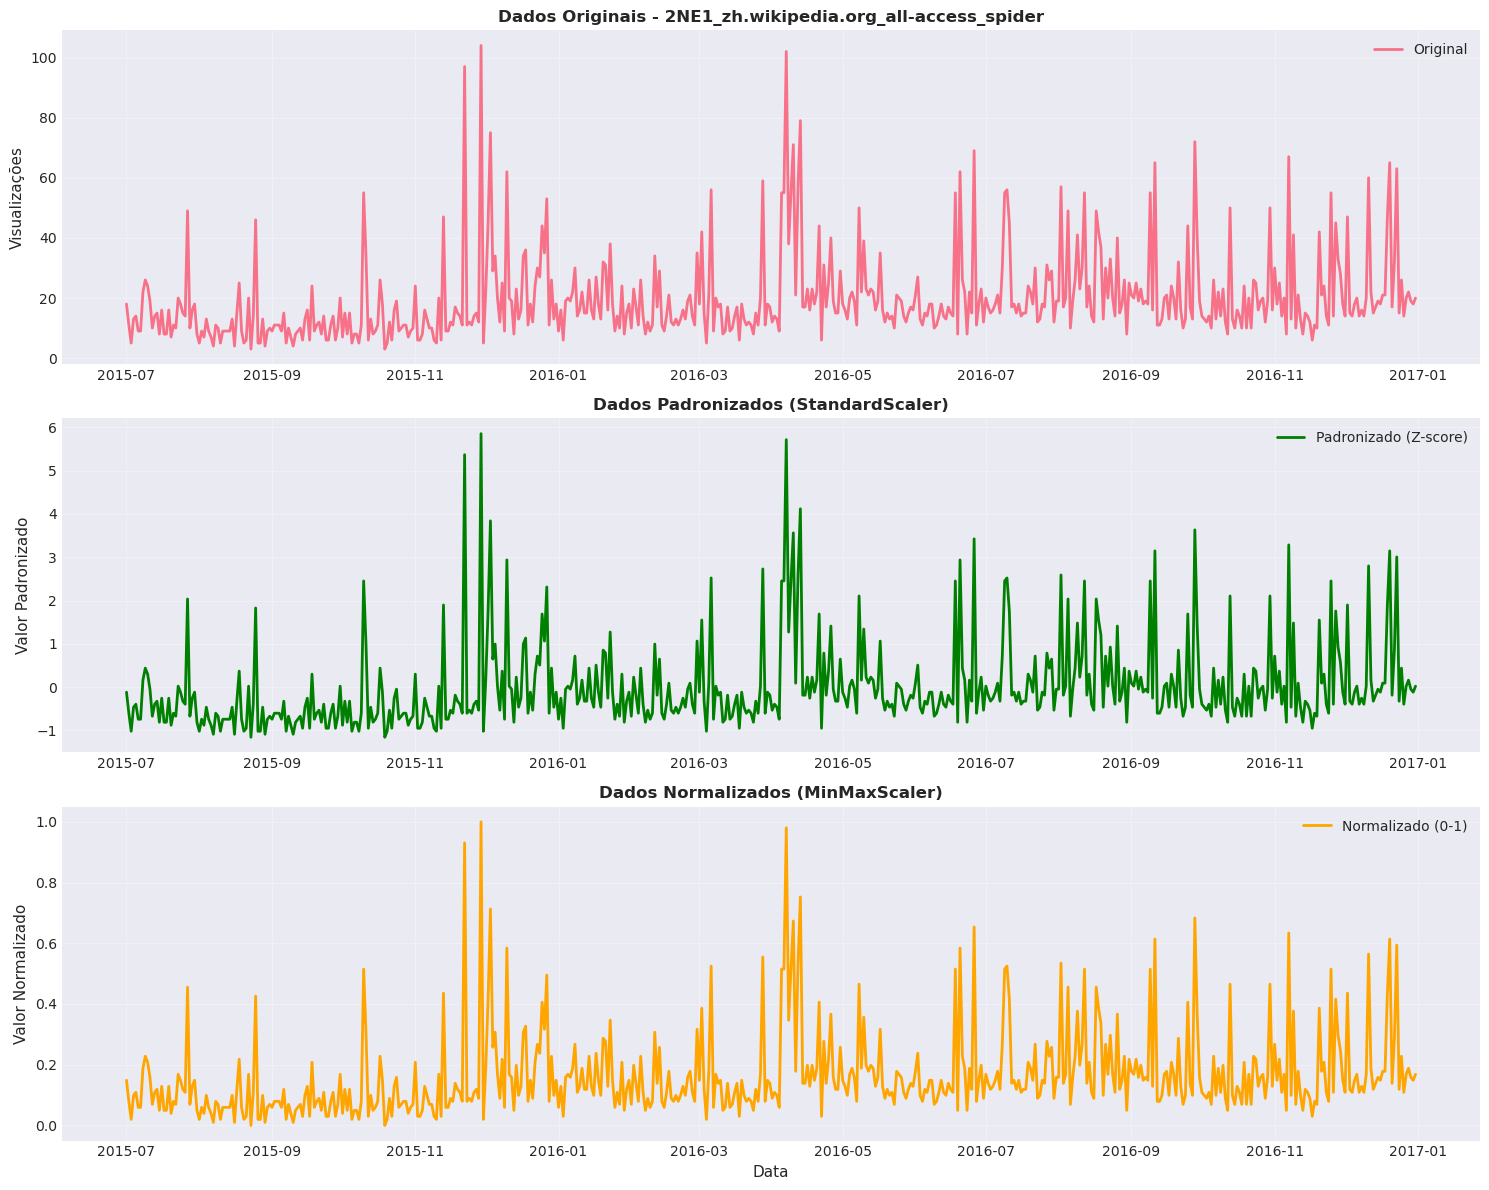


Estatísticas após transformação:

Original:
count    550.000000
mean      19.687273
std       14.413501
min        3.000000
25%       11.000000
50%       16.000000
75%       22.000000
max      104.000000
Name: Views, dtype: float64

Padronizado:
count    550.000000
mean       0.000000
std        1.000910
min       -1.158807
25%       -0.603266
50%       -0.256054
75%        0.160602
max        5.854891
Name: Views, dtype: float64

Normalizado:
count    550.000000
mean       0.165221
std        0.142708
min        0.000000
25%        0.079208
50%        0.128713
75%        0.188119
max        1.000000
Name: Views, dtype: float64


In [11]:
# Visualização do efeito da normalização
page_example = df_cleaned['Page'].unique()[0]
page_mask = df_cleaned['Page'] == page_example

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Original
axes[0].plot(df_cleaned[page_mask].sort_values('Date')['Date'],
             df_cleaned[page_mask].sort_values('Date')['Views'],
             label='Original', linewidth=2)
axes[0].set_title(f'Dados Originais - {page_example[:50]}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Visualizações', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Padronizado
axes[1].plot(df_standardized[page_mask].sort_values('Date')['Date'],
             df_standardized[page_mask].sort_values('Date')['Views'],
             label='Padronizado (Z-score)', color='green', linewidth=2)
axes[1].set_title('Dados Padronizados (StandardScaler)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Padronizado', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Normalizado
axes[2].plot(df_normalized[page_mask].sort_values('Date')['Date'],
             df_normalized[page_mask].sort_values('Date')['Views'],
             label='Normalizado (0-1)', color='orange', linewidth=2)
axes[2].set_title('Dados Normalizados (MinMaxScaler)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Data', fontsize=11)
axes[2].set_ylabel('Valor Normalizado', fontsize=11)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas comparativas
print("\nEstatísticas após transformação:")
print("\nOriginal:")
print(df_cleaned[page_mask]['Views'].describe())
print("\nPadronizado:")
print(df_standardized[page_mask]['Views'].describe())
print("\nNormalizado:")
print(df_normalized[page_mask]['Views'].describe())

## 5. Divisão dos Dados (Train/Validation/Test)

In [12]:
print("=" * 60)
print("DIVISÃO DOS DADOS")
print("=" * 60)

# Usar dados sem escalonamento para divisão
df_split = df_cleaned.copy()

# Ordenar por data
df_split = df_split.sort_values(['Page', 'Date'])

# Definir proporções (respeitando ordem temporal)
# Train: 60%, Validation: 20%, Test: 20%
train_ratio = 0.60
val_ratio = 0.20
test_ratio = 0.20

# Calcular índices de corte baseados em datas
unique_dates = df_split['Date'].unique()
n_dates = len(unique_dates)

train_end_idx = int(n_dates * train_ratio)
val_end_idx = int(n_dates * (train_ratio + val_ratio))

train_end_date = unique_dates[train_end_idx]
val_end_date = unique_dates[val_end_idx]

print(f"\nTotal de datas: {n_dates}")
print(f"\nDivisão temporal:")
print(f"  Train: até {train_end_date} ({train_ratio*100:.0f}%)")
print(f"  Validation: até {val_end_date} ({val_ratio*100:.0f}%)")
print(f"  Test: após {val_end_date} ({test_ratio*100:.0f}%)")

# Criar conjuntos
train_data = df_split[df_split['Date'] <= train_end_date].copy()
val_data = df_split[(df_split['Date'] > train_end_date) & 
                    (df_split['Date'] <= val_end_date)].copy()
test_data = df_split[df_split['Date'] > val_end_date].copy()

print(f"\nTamanhos dos conjuntos:")
print(f"  Train: {len(train_data)} registros")
print(f"  Validation: {len(val_data)} registros")
print(f"  Test: {len(test_data)} registros")

print("\n" + "=" * 60)

DIVISÃO DOS DADOS

Total de datas: 550

Divisão temporal:
  Train: até 2016-05-26 00:00:00 (60%)
  Validation: até 2016-09-13 00:00:00 (20%)
  Test: após 2016-09-13 00:00:00 (20%)

Tamanhos dos conjuntos:
  Train: 2979 registros
  Validation: 990 registros
  Test: 981 registros



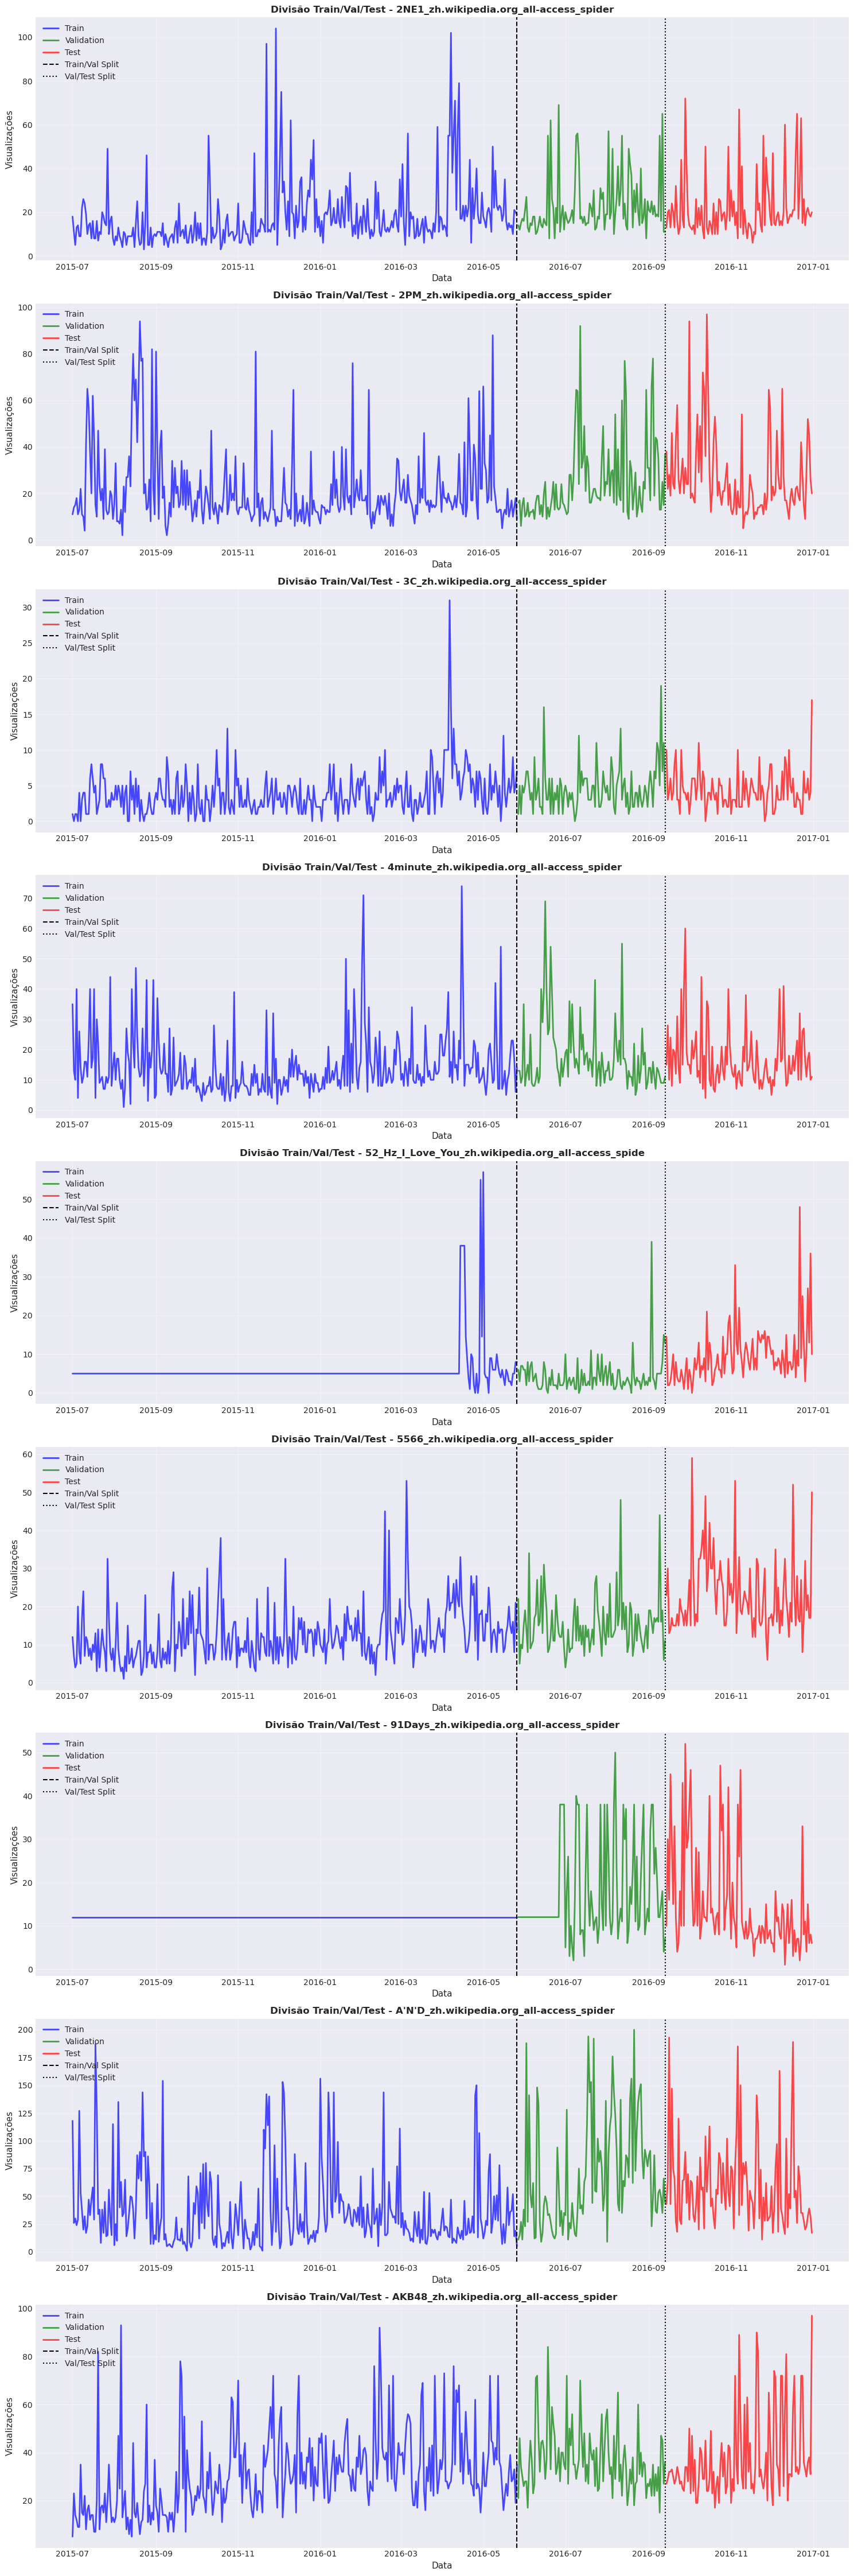

In [13]:
# Visualização da divisão
fig, axes = plt.subplots(len(df_split['Page'].unique()), 1, 
                        figsize=(15, 5*len(df_split['Page'].unique())))

if len(df_split['Page'].unique()) == 1:
    axes = [axes]

for idx, page in enumerate(df_split['Page'].unique()):
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    page_test = test_data[test_data['Page'] == page].sort_values('Date')
    
    axes[idx].plot(page_train['Date'], page_train['Views'], 
                   label='Train', color='blue', linewidth=2, alpha=0.7)
    axes[idx].plot(page_val['Date'], page_val['Views'], 
                   label='Validation', color='green', linewidth=2, alpha=0.7)
    axes[idx].plot(page_test['Date'], page_test['Views'], 
                   label='Test', color='red', linewidth=2, alpha=0.7)
    
    # Linhas verticais para separar os conjuntos
    axes[idx].axvline(x=train_end_date, color='black', linestyle='--', 
                      linewidth=1.5, label='Train/Val Split')
    axes[idx].axvline(x=val_end_date, color='black', linestyle=':', 
                      linewidth=1.5, label='Val/Test Split')
    
    axes[idx].set_title(f'Divisão Train/Val/Test - {page[:50]}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Data', fontsize=11)
    axes[idx].set_ylabel('Visualizações', fontsize=11)
    axes[idx].legend(loc='upper left')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Resumo da Preparação dos Dados

In [14]:
print("="*70)
print("RESUMO DA PREPARAÇÃO DOS DADOS")
print("="*70)

print("\n1. LIMPEZA:")
print(f"   ✓ Valores ausentes imputados")
print(f"   ✓ Outliers tratados com Winsorização")

print("\n2. TRANSFORMAÇÕES:")
print(f"   ✓ Features temporais: {len([col for col in df_cleaned.columns if any(x in col for x in ['Year', 'Month', 'Day', 'Week', 'Quarter'])])}")
print(f"   ✓ Features de lag: {len([col for col in df_cleaned.columns if 'lag' in col])}")
print(f"   ✓ Features de rolling: {len([col for col in df_cleaned.columns if 'rolling' in col])}")
print(f"   ✓ Features de diferenciação: {len([col for col in df_cleaned.columns if 'diff' in col or 'pct_change' in col])}")

print("\n3. NORMALIZAÇÃO:")
print(f"   ✓ StandardScaler aplicado")
print(f"   ✓ MinMaxScaler aplicado")

print("\n4. DIVISÃO DOS DADOS:")
print(f"   Train: {len(train_data)} registros ({len(train_data)/len(df_split)*100:.1f}%)")
print(f"   Validation: {len(val_data)} registros ({len(val_data)/len(df_split)*100:.1f}%)")
print(f"   Test: {len(test_data)} registros ({len(test_data)/len(df_split)*100:.1f}%)")

print("\n5. INFORMAÇÕES FINAIS:")
print(f"   Total de features: {len(df_cleaned.columns)}")
print(f"   Total de registros: {len(df_cleaned):,}")
print(f"   Período total: {df_cleaned['Date'].min()} a {df_cleaned['Date'].max()}")

print("\n" + "="*70)
print("PRÓXIMOS PASSOS: Etapa 3 - Modelagem Preditiva")
print("="*70)

RESUMO DA PREPARAÇÃO DOS DADOS

1. LIMPEZA:
   ✓ Valores ausentes imputados
   ✓ Outliers tratados com Winsorização

2. TRANSFORMAÇÕES:
   ✓ Features temporais: 15
   ✓ Features de lag: 4
   ✓ Features de rolling: 12
   ✓ Features de diferenciação: 4

3. NORMALIZAÇÃO:
   ✓ StandardScaler aplicado
   ✓ MinMaxScaler aplicado

4. DIVISÃO DOS DADOS:
   Train: 2979 registros (60.2%)
   Validation: 990 registros (20.0%)
   Test: 981 registros (19.8%)

5. INFORMAÇÕES FINAIS:
   Total de features: 42
   Total de registros: 4,950
   Período total: 2015-07-01 00:00:00 a 2016-12-31 00:00:00

PRÓXIMOS PASSOS: Etapa 3 - Modelagem Preditiva


In [15]:
# Salvar dados processados
print("\nSalvando dados processados...")

# Dados limpos com features
df_cleaned.to_csv('dados_limpos.csv', index=False)
print("✓ Dados limpos salvos: dados_limpos.csv")

# Dados padronizados
df_standardized.to_csv('dados_padronizados.csv', index=False)
print("✓ Dados padronizados salvos: dados_padronizados.csv")

# Dados normalizados
df_normalized.to_csv('dados_normalizados.csv', index=False)
print("✓ Dados normalizados salvos: dados_normalizados.csv")

# Conjuntos de treino/validação/teste
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
print("✓ Conjuntos separados salvos")

# Salvar metadados
metadata = {
    'train_end_date': str(train_end_date),
    'val_end_date': str(val_end_date),
    'n_features': len(df_cleaned.columns),
    'feature_names': list(df_cleaned.columns)
}

import json
with open('metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Metadados salvos: metadata.json")

print("\n✓ Todos os dados processados foram salvos com sucesso!")


Salvando dados processados...
✓ Dados limpos salvos: dados_limpos.csv
✓ Dados padronizados salvos: dados_padronizados.csv
✓ Dados normalizados salvos: dados_normalizados.csv
✓ Conjuntos separados salvos
✓ Metadados salvos: metadata.json

✓ Todos os dados processados foram salvos com sucesso!
